In [ ]:
# import json
# import matplotlib.pyplot as plt
# import numpy as np
# from datetime import datetime, timedelta, timezone
# from time import sleep

# from Functions import total_function_multiprocessing, download_show_output, getTimeseries
# from Functions import total_function_multiprocessing_lessRAM
# import pandas as pd
# pd.set_option('display.max_rows', None)

In [2]:
# TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
from Functions import total_function_multiprocessing

list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
list_event_buy_volume = [0.65, 0.75, 0.85]
list_event_volume = [4,6,8,12,20]
n_processes = 8

LOAD_DATA = False
FREE_LOCK = True

if FREE_LOCK:
    shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA)



/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-2-8-2023 does not exist. Making the request to the server..
StatusCode for getting get-benchmarkinfo: 200
total_combinantions :  5145
/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-2-8-2023 exists. Loading the file...
['/Users/albertorainieri/Projects/Personal/analysis/json/data-28-07-2023-22-42.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-06-07-2023-00-01.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-02-07-2023-06-01.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-21-07-2023-05-56.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-25-07-2023-03-40.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-19-6-2023-10-45.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-01-08-2023-19-8.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-13-07-2023-12-48.json', 

/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 1 has started
Slice 2 has started


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 3 has started


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 4 has started
Slice 5 has started


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 6 has started
Slice 7 has started


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 8 has started
1/10 of data analyzed
1/4 of data analyzed
1/2 of data analyzed
3/4 of data analyzed
size of shared_data_value before completion of 5: 3.587883 Mb; Number of events saved: 38291
size of shared_data_value before completion of 2: 8.319625 Mb; Number of events saved: 96185
size of shared_data_value before completion of 1: 11.474848 Mb; Number of events saved: 135180
size of shared_data_value before completion of 6: 15.99688 Mb; Number of events saved: 192183
size of shared_data_value before completion of 4: 22.648147 Mb; Number of events saved: 275849
size of shared_data_value before completion of 7: 26.825936 Mb; Number of events saved: 327687
size of shared_data_value before completion of 3: 32.85247 Mb; Number of events saved: 403509
size of shared_data_value before completion of 8: 38.708846 Mb; Number of events saved: 478726
pool closed
pool joined
analysis_json is loaded with file_path: /Users/albertorainieri/Projects/Personal/analysis/analysis_json/analysis.json

In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING LESS RAM

# from Functions import total_function_multiprocessing_lessRAM
# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
# list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_event_buy_volume = [0.65, 0.75, 0.85]
# list_event_volume = [4,6,8,12,20]
# n_processes = 8

# SLICE_I = 1
# LOAD_DATA = False
# FREE_LOCK = True

# if FREE_LOCK:
#     shared_data = total_function_multiprocessing_lessRAM(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, SLICE_I)

# import os
# duration = 2  # seconds
# freq = 440  # Hz
# os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))


In [1]:
# DOWNLOAD AND SHOW OUTPUT FROM TOTAL MULTIPROCESSING
from Functions import download_show_output
import pandas as pd
pd.set_option('display.max_rows', None)

minimum_event_number = 15
minimum_coin_number = 8
mean_threshold = 3
lb_threshold = -15
frequency_threshold = 5
group_coins = False
best_coins_volatility = 3

output, info = download_show_output(minimum_event_number=minimum_event_number, minimum_coin_number=minimum_coin_number,
                                      mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold,
                                       group_coins=group_coins, best_coins_volatility=best_coins_volatility)
df = pd.DataFrame(output).transpose()
df.sort_values(by=['mean'], ascending=False)
#df.sort_values(by=['lower_bound'], ascending=False)

/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Download completed in 6.93 seconds


,mean,std,upper_bound,lower_bound,n_coins,n_events,frequency/month
buy_vol_15m:0.75/vol_30m:20/timeframe:360/vlty:2,9.01,10.66,19.67,-1.65,15.0,18.0,11.25
buy_vol_3h:0.65/vol_6h:6/timeframe:180/vlty:2,8.61,10.33,18.94,-1.72,13.0,15.0,9.57
buy_vol_15m:0.75/vol_30m:20/timeframe:180/vlty:2,8.54,10.28,18.82,-1.74,15.0,19.0,11.88
buy_vol_5m:0.65/vol_60m:20/timeframe:4320/vlty:1,6.22,14.60,20.82,-8.38,14.0,19.0,7.40
buy_vol_15m:0.65/vol_24h:8/timeframe:4320/vlty:1,5.96,15.04,21.00,-9.08,14.0,17.0,7.97
buy_vol_15m:0.65/vol_60m:12/timeframe:4320/vlty:1,5.02,13.83,18.85,-8.81,14.0,18.0,10.19
buy_vol_60m:0.75/vol_3h:8/timeframe:1440/vlty:3,4.64,7.44,12.08,-2.80,16.0,16.0,10.21
buy_vol_60m:0.75/vol_60m:12/timeframe:1440/vlty:3,4.18,8.67,12.85,-4.49,16.0,16.0,14.55
buy_vol_24h:0.65/vol_6h:4/timeframe:1440/vlty:4,3.82,10.31,14.13,-6.49,14.0,15.0,8.49
buy_vol_60m:0.75/vol_60m:12/timeframe:360/vlty:3,3.44,8.24,11.68,-4.80,17.0,17.0,15.45


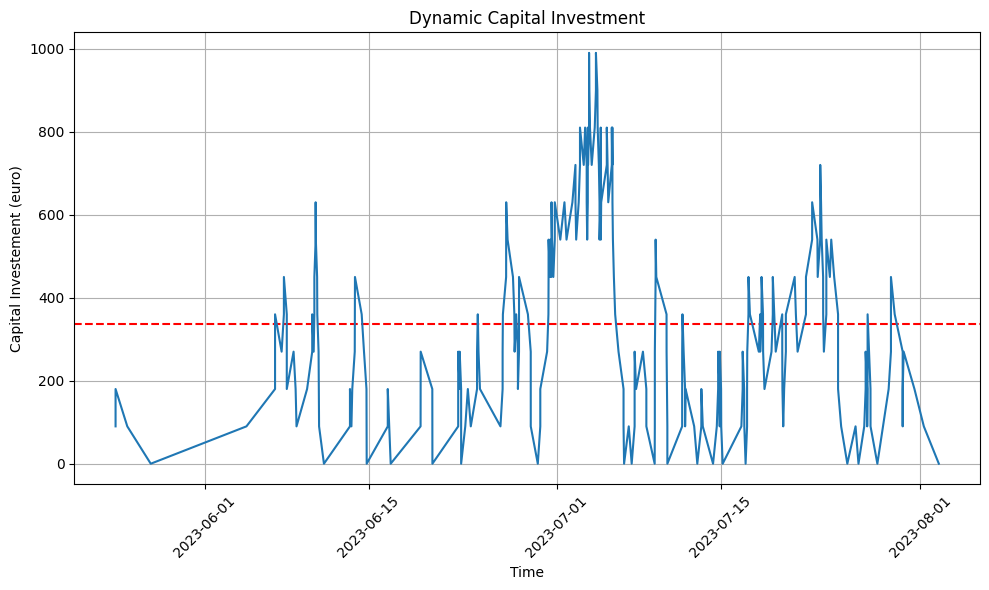

In [5]:
from Functions import check_invevestment_amount
check_invevestment_amount(info, output, investment_amount=90)

In [4]:
key = 'buy_vol_30m:0.65/vol_30m:12/timeframe:4320/vlty:1'

In [7]:
from Functions import getTimeseries
response = getTimeseries(info, key, check_past=360, look_for_newdata=True, plot=False)

File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_30m:0.65/vol_30m:12/timeframe:4320/vlty:1


,event,mean_series,mean_event,std_event,coin
0,2023-06-04T13:27:02.099567,0.038500,0.0385,0.0766,LUNCUSDT
1,2023-06-23T05:18:02.868932,0.036350,0.0342,0.0201,VETUSDT
2,2023-06-24T06:55:02.225039,0.022567,-0.0050,0.0226,GALAUSDT
3,2023-06-30T13:46:02.803124,0.001650,-0.0611,0.0192,ADADOWNUSDT
4,2023-06-30T13:48:02.263788,-0.010420,-0.0587,0.0080,BTCDOWNUSDT
5,2023-07-02T08:33:02.071889,0.171367,1.0803,0.6022,XVGUSDT
6,2023-07-17T06:22:02.881284,0.108543,-0.2684,0.0961,1INCHUSDT
7,2023-07-20T05:59:02.353163,0.089438,-0.0443,0.0313,DARUSDT
8,2023-07-21T07:26:02.909884,0.122278,0.3850,0.2795,STMXUSDT
9,2023-07-29T07:45:02.889237,0.108030,-0.0202,0.0212,STORJUSDT


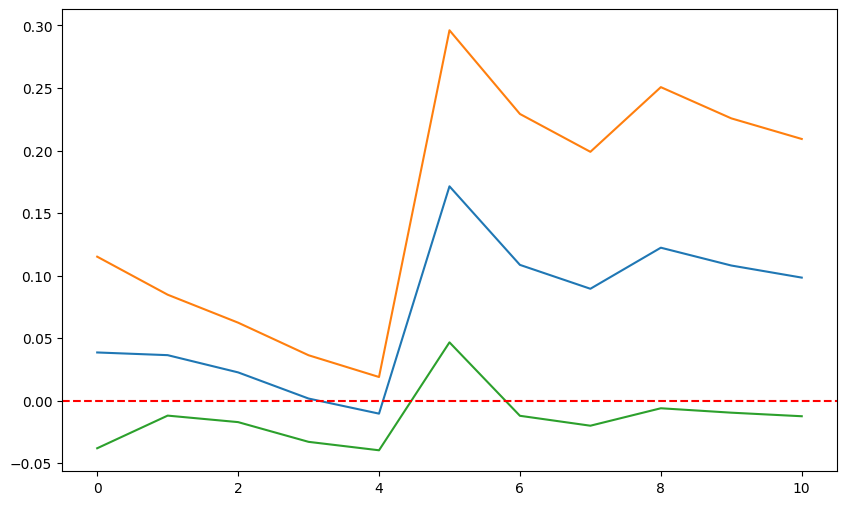

In [8]:
from Functions import infoTimeseries
#key = 'buy_vol_5m:0.65/vol_24h:8/timeframe:4320/vlty:1'
timeseries_info = infoTimeseries(info, key)
timeseries_info


In [ ]:
pd.set_option('display.max_colwidth', 1000)
#df1

In [9]:
from Functions import RiskManagement
import pandas as pd
pd.set_option('display.max_rows', None)
#key = 'buy_vol_5m:0.65/vol_30m:20/timeframe:4320/vlty:1'
df1, df2, best_risk_key = RiskManagement(key, investment_per_event=100)
df1 = df1.sort_values(by=['mean'], ascending=False)
df2 = df2.sort_values(by=['events'], ascending=True)

#result = pd.concat([df1, df2], axis=0)
print(df1)
df2

Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

300.51 euro of profit for an investment of 100 euro per event (total of 11 events). risk_golden_zone:0.3_step:0.3_step_no_golden:0.03_extratime:0.11 with 27.32 %
                                              risk_key      mean       std
429  risk_golden_zone:0.6_step:0.3_step_no_golden:0...  0.273189  0.719618
426  risk_golden_zone:0.3_step:0.3_step_no_golden:0...  0.273189  0.719618
480  risk_golden_zone:0.3_step:0.3_step_no_golden:0...  0.272052  0.720023
483  risk_golden_zone:0.6_step:0.3_step_no_golden:0...  0.272052  0.720023
372  risk_golden_zone:0.3_step:0.3_step_no_golden:0...  0.271203  0.720088
375  risk_golden_zone:0.6_step:0.3_step_no_golden:0...  0.271203  0.720088
48   risk_golden_zone:0.3_step:0.3_step_no_golden:0...  0.269788  0.720747
51   risk_golden_zone:0.6_step:0.3_step_no_golden:0...  0.269788  0.720747
213  risk_golden_zone:0.6_step:0.3_step_no_golden:0...  0.269788  0.720747
210  risk_golden_zone:0.3_step:0.3_step_no_golden:0...  0.269788  0.720747
318  risk_gol

,events,gain,buy_price,exit_price,timestamp_exit,coin,early_sell
5,2023-06-04T13:27:02.099567,-0.003181,0.000094,0.000094,2023-06-07T02:22:02.583144,LUNCUSDT,True
9,2023-06-23T05:18:02.868932,0.015757,0.017770,0.018050,2023-06-25T21:19:02.321508,VETUSDT,False
7,2023-06-24T06:55:02.225039,-0.035822,0.026520,0.025570,2023-06-26T22:56:02.140763,GALAUSDT,False
1,2023-06-30T13:46:02.803124,-0.085063,0.001975,0.001807,2023-07-03T05:46:02.904365,ADADOWNUSDT,False
3,2023-06-30T13:48:02.263788,-0.068625,0.006980,0.006501,2023-07-03T05:48:02.691292,BTCDOWNUSDT,False
0,2023-07-02T08:33:02.071889,0.981078,0.002801,0.005549,2023-07-03T08:22:02.297294,XVGUSDT,True
2,2023-07-17T06:22:02.881284,-0.351773,0.518800,0.336300,2023-07-19T22:23:02.456292,1INCHUSDT,False
4,2023-07-20T05:59:02.353163,-0.056807,0.107910,0.101780,2023-07-22T21:59:02.682335,DARUSDT,False
6,2023-07-21T07:26:02.909884,1.562238,0.005254,0.013462,2023-07-23T05:51:02.091661,STMXUSDT,True
8,2023-07-29T07:45:02.889237,-0.038486,0.309200,0.297300,2023-07-31T23:46:02.142314,STORJUSDT,False


In [2]:
from Functions import RiskConfiguration
riskmanagement_conf = (minimum_event_number, minimum_coin_number, mean_threshold, lb_threshold, frequency_threshold, group_coins, best_coins_volatility)
df  = RiskConfiguration(info, riskmanagement_conf)
df

12 keys will be analyzed in terms of risk configuration
ITERATION 1 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
2 new events for buy_vol_5m:0.65/vol_60m:20/timeframe:4320/vlty:1
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

223.97 euro of profit for an investment of 100 euro per event (total of 17 events). risk_golden_zone:1_step:0.15_step_no_golden:0.03_extratime:0.17 with 13.17 %
ITERATION 2 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
6 new events for buy_vol_15m:0.65/vol_24h:8/timeframe:4320/vlty:1
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

193.83 euro of profit for an investment of 100 euro per event (total of 15 events). risk_golden_zone:0.8_step:0.2_step_no_golden:0.03_extratime:0.33 with 12.92 %
ITERATION 3 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_3h:0.65/vol_6h:6/timeframe:180/vlty:2
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

186.52 euro of profit for an investment of 100 euro per event (total of 15 events). risk_golden_zone:1_step:0.075_step_no_golden:0.01_extratime:0.17 with 12.43 %
ITERATION 4 has started
File does not exist, Donwload from server...
Status Code is :  200
All data have been downloaded
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

197.03 euro of profit for an investment of 100 euro per event (total of 16 events). risk_golden_zone:0.8_step:0.15_step_no_golden:0.03_extratime:0.17 with 12.31 %
ITERATION 5 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
8 new events for buy_vol_24h:0.65/vol_30m:12/timeframe:1440/vlty:4
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

47.89 euro of profit for an investment of 100 euro per event (total of 23 events). risk_golden_zone:1_step:0.05_step_no_golden:0.01_extratime:0.11 with 2.08 %
ITERATION 6 has started
File does not exist, Donwload from server...
Status Code is :  200
All data have been downloaded
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

33.57 euro of profit for an investment of 100 euro per event (total of 18 events). risk_golden_zone:1_step:0.05_step_no_golden:0.03_extratime:0.11 with 1.87 %
ITERATION 7 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
2 new events for buy_vol_24h:0.65/vol_6h:4/timeframe:1440/vlty:4
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

34.31 euro of profit for an investment of 100 euro per event (total of 15 events). risk_golden_zone:1_step:0.05_step_no_golden:0.03_extratime:0.11 with 2.29 %
ITERATION 8 has started
File does not exist, Donwload from server...
Status Code is :  200
All data have been downloaded
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

140.88 euro of profit for an investment of 100 euro per event (total of 16 events). risk_golden_zone:0.8_step:0.05_step_no_golden:0.03_extratime:0.33 with 8.8 %
ITERATION 9 has started
File does not exist, Donwload from server...
Status Code is :  200
All data have been downloaded
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

243.57 euro of profit for an investment of 100 euro per event (total of 19 events). risk_golden_zone:1_step:0.075_step_no_golden:0.01_extratime:0.17 with 12.82 %
ITERATION 10 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_15m:0.75/vol_30m:20/timeframe:360/vlty:2
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

265.35 euro of profit for an investment of 100 euro per event (total of 18 events). risk_golden_zone:1_step:0.075_step_no_golden:0.05_extratime:0.33 with 14.74 %
ITERATION 11 has started
File does not exist, Donwload from server...
Status Code is :  200
All data have been downloaded
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

109.42 euro of profit for an investment of 100 euro per event (total of 17 events). risk_golden_zone:0.8_step:0.075_step_no_golden:0.05_extratime:0.17 with 6.44 %
ITERATION 12 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_60m:0.75/vol_60m:12/timeframe:1440/vlty:3
Number of combinations 486


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

152.25 euro of profit for an investment of 100 euro per event (total of 16 events). risk_golden_zone:0.8_step:0.075_step_no_golden:0.03_extratime:0.17 with 9.52 %
286.47508478164673 seconds spent to run wrap_analyze_events


,keys,golden_zone,step_golden,step_nogolden,extra_timeframe,estimated_gain,estimated_std,frequency
5,buy_vol_15m:0.75/vol_30m:20/timeframe:360/vlty:2,1,0.075,0.05,0.33,14.74,35.82,11.25
0,buy_vol_5m:0.65/vol_60m:20/timeframe:4320/vlty:1,1,0.15,0.03,0.17,13.17,52.16,7.40
1,buy_vol_15m:0.65/vol_24h:8/timeframe:4320/vlty:1,0.8,0.2,0.03,0.33,12.92,44.32,7.97
4,buy_vol_15m:0.75/vol_30m:20/timeframe:180/vlty:2,1,0.075,0.01,0.17,12.82,34.51,11.88
3,buy_vol_3h:0.65/vol_6h:6/timeframe:180/vlty:2,1,0.075,0.01,0.17,12.43,34.92,9.57
2,buy_vol_15m:0.65/vol_60m:12/timeframe:4320/vlty:1,0.8,0.15,0.03,0.17,12.31,50.32,10.19
11,buy_vol_60m:0.75/vol_60m:12/timeframe:1440/vlty:3,0.8,0.075,0.03,0.17,9.52,26.76,14.55
9,buy_vol_60m:0.75/vol_3h:8/timeframe:1440/vlty:3,0.8,0.05,0.03,0.33,8.80,25.44,10.21
10,buy_vol_60m:0.75/vol_60m:12/timeframe:360/vlty:3,0.8,0.075,0.05,0.17,6.44,21.29,15.45
8,buy_vol_24h:0.65/vol_6h:4/timeframe:1440/vlty:4,1,0.05,0.03,0.11,2.29,24.14,8.49


In [2]:
from Functions import load_riskconfiguration
#another_riskconfiguration = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2-8-2023-10-3-717.json"

another_riskconfiguration = None

df = load_riskconfiguration(another_riskconfiguration)
df

Estimated gain each month: 1156 euro with investment amount 100 euro per event
{
    "minimum_event_number": 15,
    "minimum_coin_number": 8,
    "mean_threshold": 3,
    "lb_threshold": -15,
    "frequency_threshold": 5,
    "group_coins": false,
    "best_coins_volatility": 3,
    "timestamp": "2023-08-03T09:22:25.534621"
}


,keys,golden_zone,step_golden,step_nogolden,extra_timeframe,estimated_gain,estimated_std,frequency
5,buy_vol_15m:0.75/vol_30m:20/timeframe:360/vlty:2,1,0.075,0.05,0.33,14.74,35.82,11.25
0,buy_vol_5m:0.65/vol_60m:20/timeframe:4320/vlty:1,1,0.15,0.03,0.17,13.17,52.16,7.40
1,buy_vol_15m:0.65/vol_24h:8/timeframe:4320/vlty:1,0.8,0.2,0.03,0.33,12.92,44.32,7.97
4,buy_vol_15m:0.75/vol_30m:20/timeframe:180/vlty:2,1,0.075,0.01,0.17,12.82,34.51,11.88
3,buy_vol_3h:0.65/vol_6h:6/timeframe:180/vlty:2,1,0.075,0.01,0.17,12.43,34.92,9.57
2,buy_vol_15m:0.65/vol_60m:12/timeframe:4320/vlty:1,0.8,0.15,0.03,0.17,12.31,50.32,10.19
11,buy_vol_60m:0.75/vol_60m:12/timeframe:1440/vlty:3,0.8,0.075,0.03,0.17,9.52,26.76,14.55
9,buy_vol_60m:0.75/vol_3h:8/timeframe:1440/vlty:3,0.8,0.05,0.03,0.33,8.80,25.44,10.21
10,buy_vol_60m:0.75/vol_60m:12/timeframe:360/vlty:3,0.8,0.075,0.05,0.17,6.44,21.29,15.45
8,buy_vol_24h:0.65/vol_6h:4/timeframe:1440/vlty:4,1,0.05,0.03,0.11,2.29,24.14,8.49


In [1]:
from Functions import send_riskconfiguration
response = send_riskconfiguration()

/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Status Code is :  200
